# Initialize and import dataset

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import bq_helper
from bq_helper import BigQueryHelper

In [2]:
#Import dataset from Google BigQuery
chicago_crime = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="chicago_crime")
bq_assistant = BigQueryHelper("bigquery-public-data", "chicago_crime")
bq_assistant.list_tables()



Using Kaggle's public dataset BigQuery integration.
Using Kaggle's public dataset BigQuery integration.


['crime']

In [3]:
#Query the relevant columns and years.
feature_query = """
                SELECT DATE(date) as ds,primary_type,community_area, location_description
                FROM  `bigquery-public-data.chicago_crime.crime`
                where year > 2010
                """
#Convert from query to pandas type
crimes = chicago_crime.query_to_pandas_safe(feature_query)


In [4]:
#From string to datetime type
crimes['ds'] = pd.to_datetime(crimes['ds'])

#Plots for Corona-trends
crime_count = pd.DataFrame(crimes[crimes["ds"] > '2020-01-01'].groupby('primary_type').size().sort_values(ascending=False).rename('counts').reset_index()).head(5)
crime_count.head(10)
day_count_narcotics = pd.DataFrame(crimes[crimes["primary_type"]=="NARCOTICS"].groupby('ds').size().sort_values(ascending=False).rename('counts').reset_index())
day_count_narcotics.counts.mean()


61.383846794338055

# Summary statistics

In [5]:
#Summary statistics
crimes['YearMonth'] = pd.to_datetime(crimes['ds']).apply(lambda x: '{year}-{month}'.format(year=x.year, month=x.month))

res = crimes.groupby('YearMonth').size().sort_values(ascending=False)
res.to_csv('monthlycsvfile.csv',index=False)

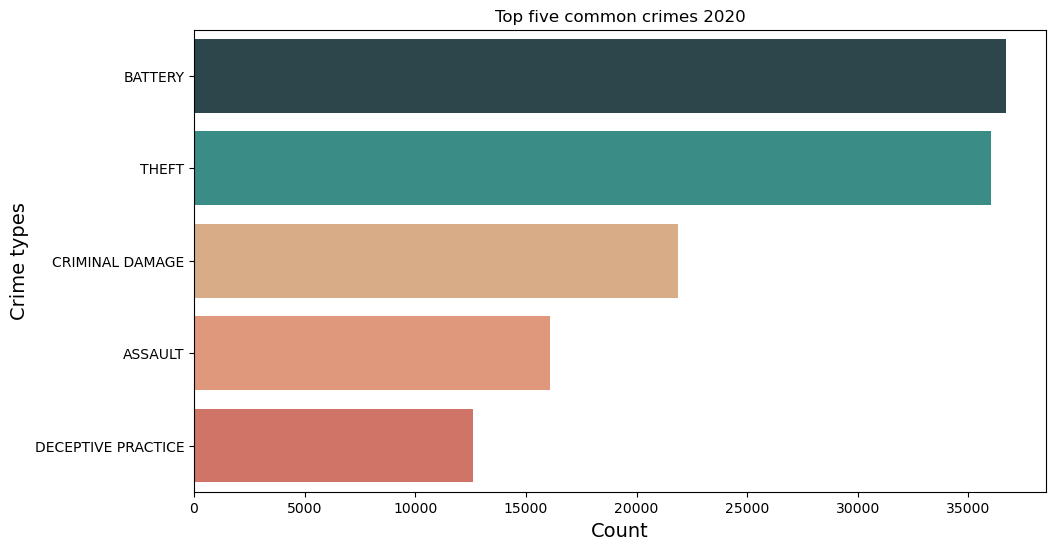

In [55]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.reset_defaults()
fig = plt.figure(figsize=(11,6))

ax=sns.countplot(y='primary_type',data=crimes[(crimes["ds"]>"2020-01-01") & (crimes["ds"]<="2020-12-31")],order = crimes[(crimes["ds"]>"2020-01-01") & (crimes["ds"]<="2020-12-31")]['primary_type'].value_counts().iloc[:5].index,palette= ['#274950','#2D9991','#E7AB7A','#F1906C','#E36656'])#   palette=["blue","red","yellow","green","magenta"])
plt.xlabel("Count",size=14)
plt.ylabel("Crime types",size=14)
plt.xticks(size=10)
plt.yticks(size=10)
plt.title("Top five common crimes 2020")


plt.show()



Battery is most common crime in 2020

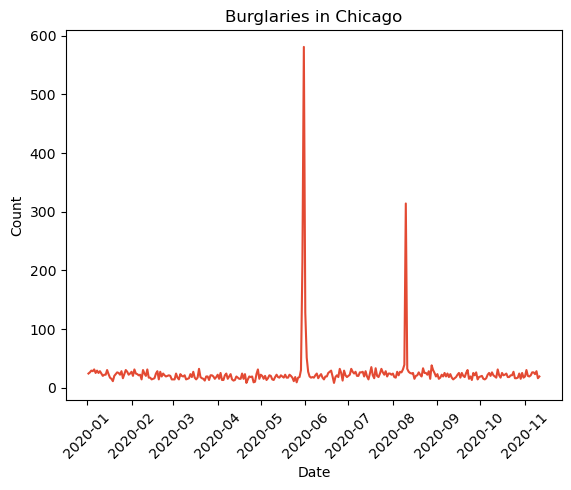

In [58]:
sns.reset_defaults()
narc_crimes = crimes[(crimes["ds"]>'2020-01-01')]# & (crimes["ds"]<'2020-09-01')]
narc_crimes = narc_crimes[narc_crimes["primary_type"]=="BURGLARY"]
#narc_crimes = narc_crimes[narc_crimes["community_area"]==8]
narc_crimes_count = narc_crimes.groupby("ds").count()
narc_crimes_count
#fig = Figure()
sns.lineplot(x=narc_crimes_count.index,y=narc_crimes_count.primary_type,color = "#e34a33")
plt.xticks(rotation=45)


plt.ylabel("Count")
plt.xlabel("Date")
plt.title("Burglaries in Chicago")
plt.show()



BLM and George Floyd protests has massive impact on burglaries

# Methods


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_weekly, plot_yearly,plot_forecast_component, seasonality_plot_df, plot

from matplotlib.dates import (
        MonthLocator,
        num2date,
        AutoDateLocator,
        AutoDateFormatter,
    )

In [19]:
#Input list of crimes and returns forecast data
def prophet_data(primary_type_lst):   

    prophet_m_lst = []
    prophet_forecast_lst = []
    for primary_type in primary_type_lst:

        crime = crimes[crimes["primary_type"] == primary_type]
        crime_days = crime.groupby(pd.Grouper(key="ds", freq="1D")).count()
        df = pd.DataFrame()
    
        df["ds"] = crime_days.index
        try:
            df[["y","y2"]] = crime_days.values
        except:
            df[["y","y2",'y3','y4']] = crime_days.values
        
        m = Prophet(seasonality_mode = 'multiplicative')
        m.fit(df)
        future = m.make_future_dataframe(periods=0, freq='d')
        forecast = m.predict(future)
        prophet_m_lst.append(m)
        prophet_forecast_lst.append(forecast)
    return prophet_m_lst, prophet_forecast_lst
    
    
    

In [10]:
#Change Facebook Prophet method to custom change colors.
def plot_new_forecast_component(
    m, fcst, name, ax=None,col='#00b240', uncertainty=True, plot_cap=False, figsize=(10, 6)
):
    """Plot a particular component of the forecast.
    Parameters
    ----------
    m: Prophet model.
    fcst: pd.DataFrame output of m.predict.
    name: Name of the component to plot.
    ax: Optional matplotlib Axes to plot on.
    uncertainty: Optional boolean to plot uncertainty intervals.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    figsize: Optional tuple width, height in inches.
    Returns
    -------
    a list of matplotlib artists
    """
    artists = []
    if not ax:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    fcst_t = fcst['ds'].dt.to_pydatetime()
    artists += ax.plot(fcst_t, fcst[name], ls='-', c=col)
    if 'cap' in fcst and plot_cap:
        artists += ax.plot(fcst_t, fcst['cap'], ls='--', c='k')
    if m.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k')
    if uncertainty:
        artists += [ax.fill_between(
            fcst_t, fcst[name + '_lower'], fcst[name + '_upper'],
            color='#0072B2', alpha=0.2)]
    # Specify formatting to workaround matplotlib issue #12925
    locator = AutoDateLocator(interval_multiples=False)
    formatter = AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel('time ')
    ax.set_ylabel(name)
    if name in m.component_modes['multiplicative']:
        ax = set_y_as_percent(ax)
    return artists

In [11]:
#Customized to change colors in plot
import datetime as dt
def set_y_as_percent(ax):
    yticks = 100 * ax.get_yticks()
    yticklabels = ['{0:.4g}%'.format(y) for y in yticks]
    ax.set_yticklabels(yticklabels)
    return ax

def plot_weekly(m, ax=None,col = '#0072B2',  uncertainty=True, weekly_start=0, figsize=(10, 6), name='weekly'):
    """Plot the weekly component of the forecast.
    Parameters
    ----------
    m: Prophet model.
    ax: Optional matplotlib Axes to plot on. One will be created if this
        is not provided.
    uncertainty: Optional boolean to plot uncertainty intervals.
    weekly_start: Optional int specifying the start day of the weekly
        seasonality plot. 0 (default) starts the week on Sunday. 1 shifts
        by 1 day to Monday, and so on.
    figsize: Optional tuple width, height in inches.
    name: Name of seasonality component if changed from default 'weekly'.
    Returns
    -------
    a list of matplotlib artists
    """
    artists = []
    if not ax:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    # Compute weekly seasonality for a Sun-Sat sequence of dates.
    days = (pd.date_range(start='2017-01-01', periods=7) +
            pd.Timedelta(days=weekly_start))
    df_w = seasonality_plot_df(m, days)
    seas = m.predict_seasonal_components(df_w)
    days = days.day_name()
    artists += ax.plot(range(len(days)), seas[name], ls='-',
                    c=col)
    if uncertainty:
        artists += [ax.fill_between(range(len(days)),
                                    seas[name + '_lower'], seas[name + '_upper'],
                                    color='#0072B2', alpha=0.2)]
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xticks(range(len(days)))
    ax.set_xticklabels(days)
    ax.set_xlabel('Day of week')
    ax.set_ylabel(name)
    if m.seasonalities[name]['mode'] == 'multiplicative':
        ax = set_y_as_percent(ax)
    return artists

from matplotlib.ticker import FuncFormatter

def plot_yearly(m, ax=None, col = "r",uncertainty=True, yearly_start=0, figsize=(10, 6), name='yearly'):
    """Plot the yearly component of the forecast.
    Parameters
    ----------
    m: Prophet model.
    ax: Optional matplotlib Axes to plot on. One will be created if
        this is not provided.
    uncertainty: Optional boolean to plot uncertainty intervals.
    yearly_start: Optional int specifying the start day of the yearly
        seasonality plot. 0 (default) starts the year on Jan 1. 1 shifts
        by 1 day to Jan 2, and so on.
    figsize: Optional tuple width, height in inches.
    name: Name of seasonality component if previously changed from default 'yearly'.
    Returns
    -------
    a list of matplotlib artists
    """
    artists = []
    if not ax:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    # Compute yearly seasonality for a Jan 1 - Dec 31 sequence of dates.
    days = (pd.date_range(start='2017-01-01', periods=365) +
            pd.Timedelta(days=yearly_start))
    df_y = seasonality_plot_df(m, days)
    seas = m.predict_seasonal_components(df_y)
    artists += ax.plot(
        df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c=col)
    if uncertainty:
        artists += [ax.fill_between(
            df_y['ds'].dt.to_pydatetime(), seas[name + '_lower'],
            seas[name + '_upper'], color='#0072B2', alpha=0.2)]
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    months = MonthLocator(range(1, 13), bymonthday=1, interval=2)
    ax.xaxis.set_major_formatter(FuncFormatter(
        lambda x, pos=None: '{dt:%B} {dt.day}'.format(dt=num2date(x))))
    ax.xaxis.set_major_locator(months)
    ax.set_xlabel('Day of year')
    ax.set_ylabel(name)
    if m.seasonalities[name]['mode'] == 'multiplicative':
        ax = set_y_as_percent(ax)
    return artists


# Forecasting

In [61]:
#Generate lists ready for forecasting
crimes_2020 = pd.DataFrame(crimes[(crimes["ds"] >= '2020-01-01') & (crimes["ds"] <= '2020-11-03')])

crime_count = pd.DataFrame(crimes_2020.groupby('primary_type').size().sort_values(ascending=False).rename('counts').reset_index())

prophet_m_lst,prophet_forecast_lst = prophet_data(crime_count.head()["primary_type"])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


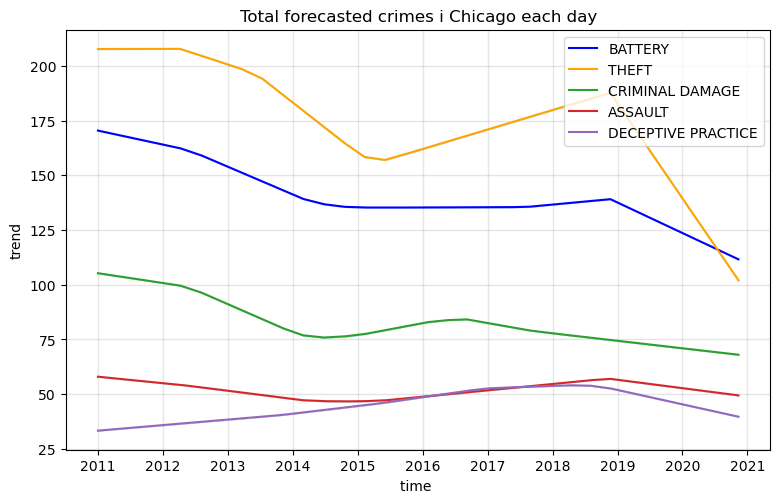

In [62]:
#Plot all crimes in samme figure

fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 1)
col_lst = ['blue','orange','#2ca02c','#d62728','#9467bd']    #['#274950','#2D9991','#E7AB7A','#F1906C','#E36656']
for i in range(len(prophet_m_lst)):
    fig = plot_new_forecast_component(m=prophet_m_lst[i], fcst=prophet_forecast_lst[i], name='trend',col=col_lst[i],ax=ax1)
    plt.legend(crime_count.head()["primary_type"])
plt.title("Total forecasted crimes i Chicago each day")
plt.show()



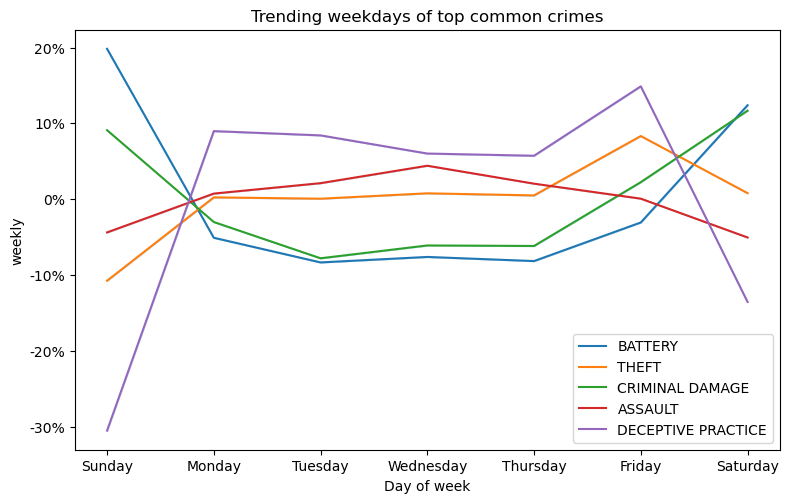

In [63]:
#Plot all crimes in same figure weekly
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(2, 2, 1)
col_lst = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd']#['#274950','#2D9991','#E7AB7A','#F1906C','#E36656']
for i in range(len(prophet_m_lst)):
    fig = plot_weekly(m=prophet_m_lst[i],ax=ax1,col = col_lst[i])
    plt.legend(crime_count.head()["primary_type"])
ax1.grid(False)
plt.title("Trending weekdays of top common crimes")
plt.show()

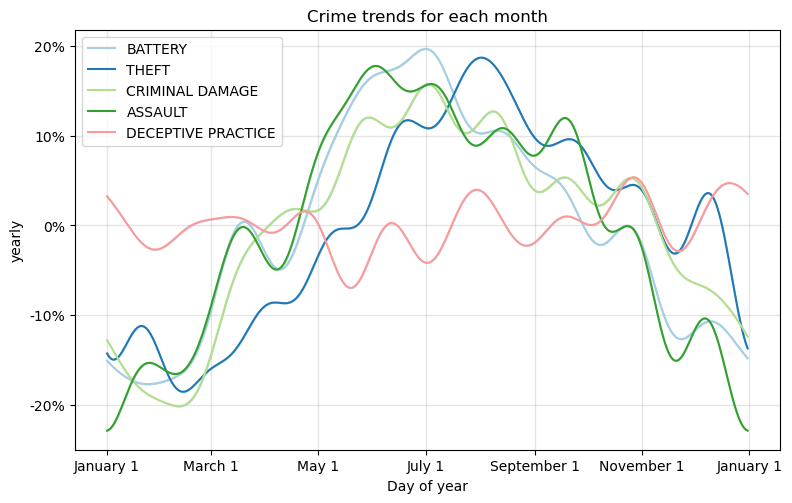

In [64]:
#Plot all crimes in same figure yearly
sns.reset_defaults()
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(2, 2, 1)
col_lst =['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99']
for i in range(len(prophet_m_lst)):
    fig = plot_yearly(m=prophet_m_lst[i],ax=ax1,col = col_lst[i])
    plt.legend(crime_count.head()["primary_type"])
plt.title("Crime trends for each month")
plt.show()

# Top trending crimes by area

In [29]:
crimes_2019 = pd.DataFrame(crimes[(crimes["ds"] >= '2018-11-03') & (crimes["ds"] <= '2019-11-03')].groupby('primary_type').size().sort_values(ascending=False).rename('counts').reset_index())
crimes_2020 = pd.DataFrame(crimes[crimes["ds"] > '2019-11-03'].groupby('primary_type').size().sort_values(ascending=False).rename('counts').reset_index())
crimes_diff = crimes_2020


#print(crimes_2020.head())
#print(crimes_2019.head())
#print(crimes_diff.head())


crimes_2020_top_locations = crimes.groupby("community_area").size().sort_values(ascending =False).head(20) 
crimes_2020_top_locations.head()

community_area
25.0    173691
8.0     105695
43.0     93776
29.0     89866
23.0     88112
dtype: int64

# Top trending crimes

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


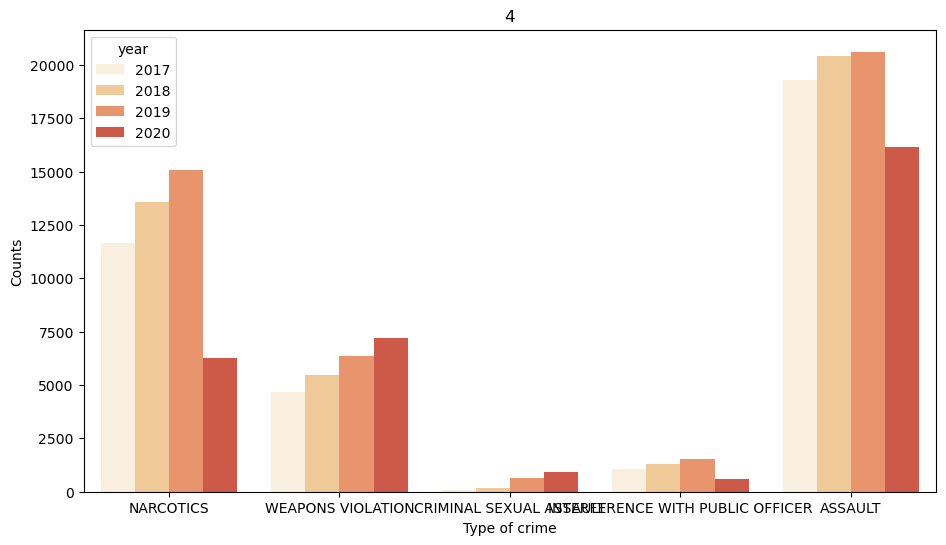

In [31]:
community_crimes_2019 = pd.DataFrame(crimes[(crimes["ds"] >= '2019-01-01') & (crimes["ds"] <= '2019-12-31')].groupby('primary_type').size().sort_values(ascending=False).rename('counts').reset_index())
community_crimes_2020 = pd.DataFrame(crimes[(crimes["ds"] >= '2020-01-01')].groupby('primary_type').size().sort_values(ascending=False).rename('counts_20').reset_index())
community_crimes_2018 = pd.DataFrame(crimes[(crimes["ds"] >= '2018-01-01') & (crimes["ds"] <= '2018-12-31')].groupby('primary_type').size().sort_values(ascending=False).rename('counts_18').reset_index())
community_crimes_2017 = pd.DataFrame(crimes[(crimes["ds"] >= '2017-01-01') & (crimes["ds"] <= '2017-12-31')].groupby('primary_type').size().sort_values(ascending=False).rename('counts_17').reset_index())


crimes_diff = community_crimes_2020.copy()


community_crimes_2020["diff"] = 0
community_crimes_2020["counts_19"] = 0
community_crimes_2020["counts_18"] = 0
community_crimes_2020["counts_17"] = 0



for j in community_crimes_2019.iloc:
    count_19 = j["counts"]
    community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"diff"]= community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"]]["counts_20"] - count_19
    community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"counts_19"]= count_19

for j in community_crimes_2018.iloc:
    count_18 = j["counts_18"]
    community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"diff"]= community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"]]["counts_20"] - count_18
    community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"counts_18"]= count_18

for j in community_crimes_2017.iloc:
    count_17 = j["counts_17"]
    community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"counts_17"]= count_17
    community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"diff"]= community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"]]["counts_20"] - count_17

community_crimes_2020["diff2"] = community_crimes_2020["counts_19"]-community_crimes_2020["counts_18"]
community_crimes_2020["avg_change"] = community_crimes_2020["counts_19"]-community_crimes_2020["counts_18"]



community_crimes_2020 = community_crimes_2020[["primary_type","counts_19","counts_20","counts_18","counts_17","diff2","avg_change"]]
community_crimes_2020.sort_values("diff2",ascending = False).head()


fig = plt.figure(figsize=(11,6))# Create matplotlib figure
plt.rcParams.update({'font.size': 10})

ax = fig.add_subplot(111) # Create matplotlib axes
width = 0.4

community_crimes_2020 = community_crimes_2020.sort_values("avg_change",ascending=False).head(5)

count_2018 = community_crimes_2020[["primary_type","counts_18","avg_change"]]
count_2019 = community_crimes_2020[["primary_type","counts_19","avg_change"]]
count_2020 = community_crimes_2020[["primary_type","counts_20","avg_change"]]
count_2017 = community_crimes_2020[["primary_type","counts_17","avg_change"]]

count_2019 = count_2019.rename(columns={"counts_19":"counts_20"})
count_2018 = count_2018.rename(columns={"counts_18":"counts_20"})
count_2017 = count_2017.rename(columns={"counts_17":"counts_20"})
x = []
y= []
z =[]
k=[]
for j in range(5):
    x.append(2019)
for j in range(5):
    y.append(2020)
for j in range(5):
    z.append(2018)
for j in range(5):
    k.append(2017)

count_2019["year"] = x
count_2020["year"] = y
count_2018["year"] = z
count_2017["year"] = k

count_all = pd.concat([count_2018,count_2017,count_2019,count_2020],ignore_index=True) 


graph = sns.barplot(x=count_all.primary_type,y=count_all.counts_20,hue=count_all.year,palette = ['#fef0d9','#fdcc8a','#fc8d59','#e34a33','#b30000'])

count_all 
plt.xlabel("Type of crime")
plt.ylabel("Counts")
plt.title("Most increasing crimes in Chicago")


plt.show()



    


Narcotics is the one crime increasing the most

# Top trending crimes in top areas

In [35]:
sns.color_palette("tab10")
#Methods for plotting crimes for each area

def plot_change_areas(community_areas_lst):

    for i in community_areas_lst:



        community_crimes_2019 = pd.DataFrame(crimes[(crimes["ds"] >= '2019-01-01') & (crimes["ds"] <= '2019-12-31') & (crimes["community_area"]==i)].groupby('primary_type').size().sort_values(ascending=False).rename('counts').reset_index())
        community_crimes_2020 = pd.DataFrame(crimes[(crimes["ds"] >= '2020-01-01') & (crimes["ds"] <= '2020-11-01') & (crimes["community_area"]==i)].groupby('primary_type').size().sort_values(ascending=False).rename('counts_20').reset_index())
        community_crimes_2018 = pd.DataFrame(crimes[(crimes["ds"] >= '2018-01-01') & (crimes["ds"] <= '2018-12-31') & (crimes["community_area"]==i)].groupby('primary_type').size().sort_values(ascending=False).rename('counts_18').reset_index())
        community_crimes_2017 = pd.DataFrame(crimes[(crimes["ds"] >= '2017-01-01') & (crimes["ds"] <= '2017-12-31') & (crimes["community_area"]==i)].groupby('primary_type').size().sort_values(ascending=False).rename('counts_17').reset_index())


        crimes_diff = community_crimes_2020.copy()


        community_crimes_2020["diff"] = 0
        community_crimes_2020["counts_19"] = 0
        community_crimes_2020["counts_18"] = 0
        community_crimes_2020["counts_17"] = 0



        for j in community_crimes_2019.iloc:
            count_19 = j["counts"]
            community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"diff"]= community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"]]["counts_20"] - count_19
            community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"counts_19"]= count_19

        for j in community_crimes_2018.iloc:
            count_18 = j["counts_18"]
            community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"diff"]= community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"]]["counts_20"] - count_18
            community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"counts_18"]= count_18

        for j in community_crimes_2017.iloc:
            count_17 = j["counts_17"]
            community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"counts_17"]= count_17
            community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"diff"]= community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"]]["counts_20"] - count_17


        #print(crimes_2020.head())

        community_crimes_2020["perc_change"] = community_crimes_2020["counts_19"]-community_crimes_2020["counts_18"]
        community_crimes_2020["avg_change"] = community_crimes_2020["counts_19"]-community_crimes_2020["counts_17"]

        #print(crimes_diff.head())

        community_crimes_2020 = community_crimes_2020[["primary_type","counts_19","counts_20","counts_18","counts_17","diff","perc_change","avg_change"]]
        community_crimes_2020.sort_values("perc_change",ascending = False).head()

        #community_crimes_2020.sort_values("perc_change")[["primary_type","perc_change"]].set_index("primary_type").plot.bar()


        fig = plt.figure(figsize=(30,8))# Create matplotlib figure

        ax = fig.add_subplot(111) # Create matplotlib axes
        width = 0.4


        #community_crimes_2020.set_index("primary_type").sort_values("perc_change",ascending=False).head(5).counts_20.plot(kind='bar', color='red', ax=ax, width=width, position=0)
        #community_crimes_2020.set_index("primary_type").sort_values("perc_change",ascending=False).head(5).counts_19.plot(kind='bar', color='blue', ax=ax, width=width, position=1)
        #community_crimes_2020.set_index("primary_type").sort_values("perc_change",ascending=False).head(10).counts_18.plot(kind='bar', color='green', ax=ax, width=width, position=2)

        community_crimes_2020 = community_crimes_2020.sort_values("avg_change",ascending=False).head(10)

        count_2018 = community_crimes_2020[["primary_type","counts_18","avg_change"]]
        count_2019 = community_crimes_2020[["primary_type","counts_19","avg_change"]]
        count_2020 = community_crimes_2020[["primary_type","counts_20","avg_change"]]
        count_2017 = community_crimes_2020[["primary_type","counts_17","avg_change"]]

        count_2019 = count_2019.rename(columns={"counts_19":"counts_20"})
        count_2018 = count_2018.rename(columns={"counts_18":"counts_20"})
        count_2017 = count_2017.rename(columns={"counts_17":"counts_20"})
        x = []
        y= []
        z =[]
        k=[]
        for j in range(10):
            x.append(2019)
        for j in range(10):
            y.append(2020)
        for j in range(10):
            z.append(2018)
        for j in range(10):
            k.append(2017)

        count_2019["year"] = x
        count_2020["year"] = y
        count_2018["year"] = z
        count_2017["year"] = k

        count_all = pd.concat([count_2018,count_2017,count_2019,count_2020],ignore_index=True) 


        sns.barplot(x=count_all.primary_type,y=count_all.counts_20,hue=count_all.year,palette = ['#fef0d9','#fdcc8a','#fc8d59','#e34a33','#b30000'])

        count_all 
        plt.xlabel("Type of crime")
        plt.ylabel("Counts")
        plt.title(str(i))
        
        
    plt.show()
        

#plot_change_areas(crimes_2020_top_locations.index)

def generate_community_crimes(community_areas_lst):
       
    
    community_crimes_lst = []
    for i in community_areas_lst:


        community_crimes_2019 = pd.DataFrame(crimes[(crimes["ds"] >= '2019-01-01') & (crimes["ds"] <= '2019-12-31') & (crimes["community_area"]==i)].groupby('primary_type').size().sort_values(ascending=False).rename('counts').reset_index())
        community_crimes_2020 = pd.DataFrame(crimes[(crimes["ds"] >= '2020-01-01') & (crimes["ds"] <= '2020-12-31') & (crimes["community_area"]==i)].groupby('primary_type').size().sort_values(ascending=False).rename('counts_20').reset_index())
        community_crimes_2018 = pd.DataFrame(crimes[(crimes["ds"] >= '2018-01-01') & (crimes["ds"] <= '2018-12-31') & (crimes["community_area"]==i)].groupby('primary_type').size().sort_values(ascending=False).rename('counts_18').reset_index())
        community_crimes_2017 = pd.DataFrame(crimes[(crimes["ds"] >= '2017-01-01') & (crimes["ds"] <= '2017-12-31') & (crimes["community_area"]==i)].groupby('primary_type').size().sort_values(ascending=False).rename('counts_17').reset_index())


        crimes_diff = community_crimes_2020.copy()


        community_crimes_2020["diff"] = 0
        community_crimes_2020["counts_19"] = 0
        community_crimes_2020["counts_18"] = 0
        community_crimes_2020["counts_17"] = 0

        

        for j in community_crimes_2019.iloc:
            count_19 = j["counts"]
            community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"diff"]= community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"]]["counts_20"] - count_19
            community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"counts_19"]= count_19

            
        for j in community_crimes_2018.iloc:
            count_18 = j["counts_18"]
            community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"diff"]= community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"]]["counts_20"] - count_18
            community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"counts_18"]= count_18
            
        for j in community_crimes_2017.iloc:
            count_17 = j["counts_17"]
            community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"diff"]= community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"]]["counts_20"] - count_17
            community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"counts_17"]= count_17
        
        #print(crimes_2020.head())

        community_crimes_2020["perc_change"] = community_crimes_2020["diff"]/community_crimes_2020["counts_19"]
        community_crimes_2020["17_diff"] = community_crimes_2020["counts_19"]-community_crimes_2020["counts_17"]

        #print(crimes_diff.head())

        community_crimes_2020 = community_crimes_2020[["primary_type","counts_19","counts_20","counts_18","counts_17","diff","perc_change","17_diff"]]
        community_crimes_2020.sort_values("17_diff",ascending = False).head()
        community_crimes_lst.append([i,community_crimes_2020])

      
        community_crimes_2020.set_index("primary_type")

    return community_crimes_lst



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

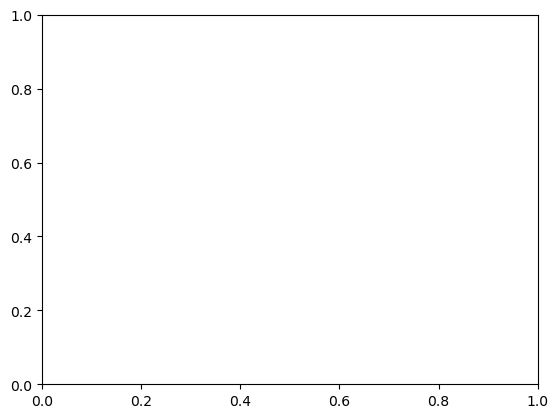

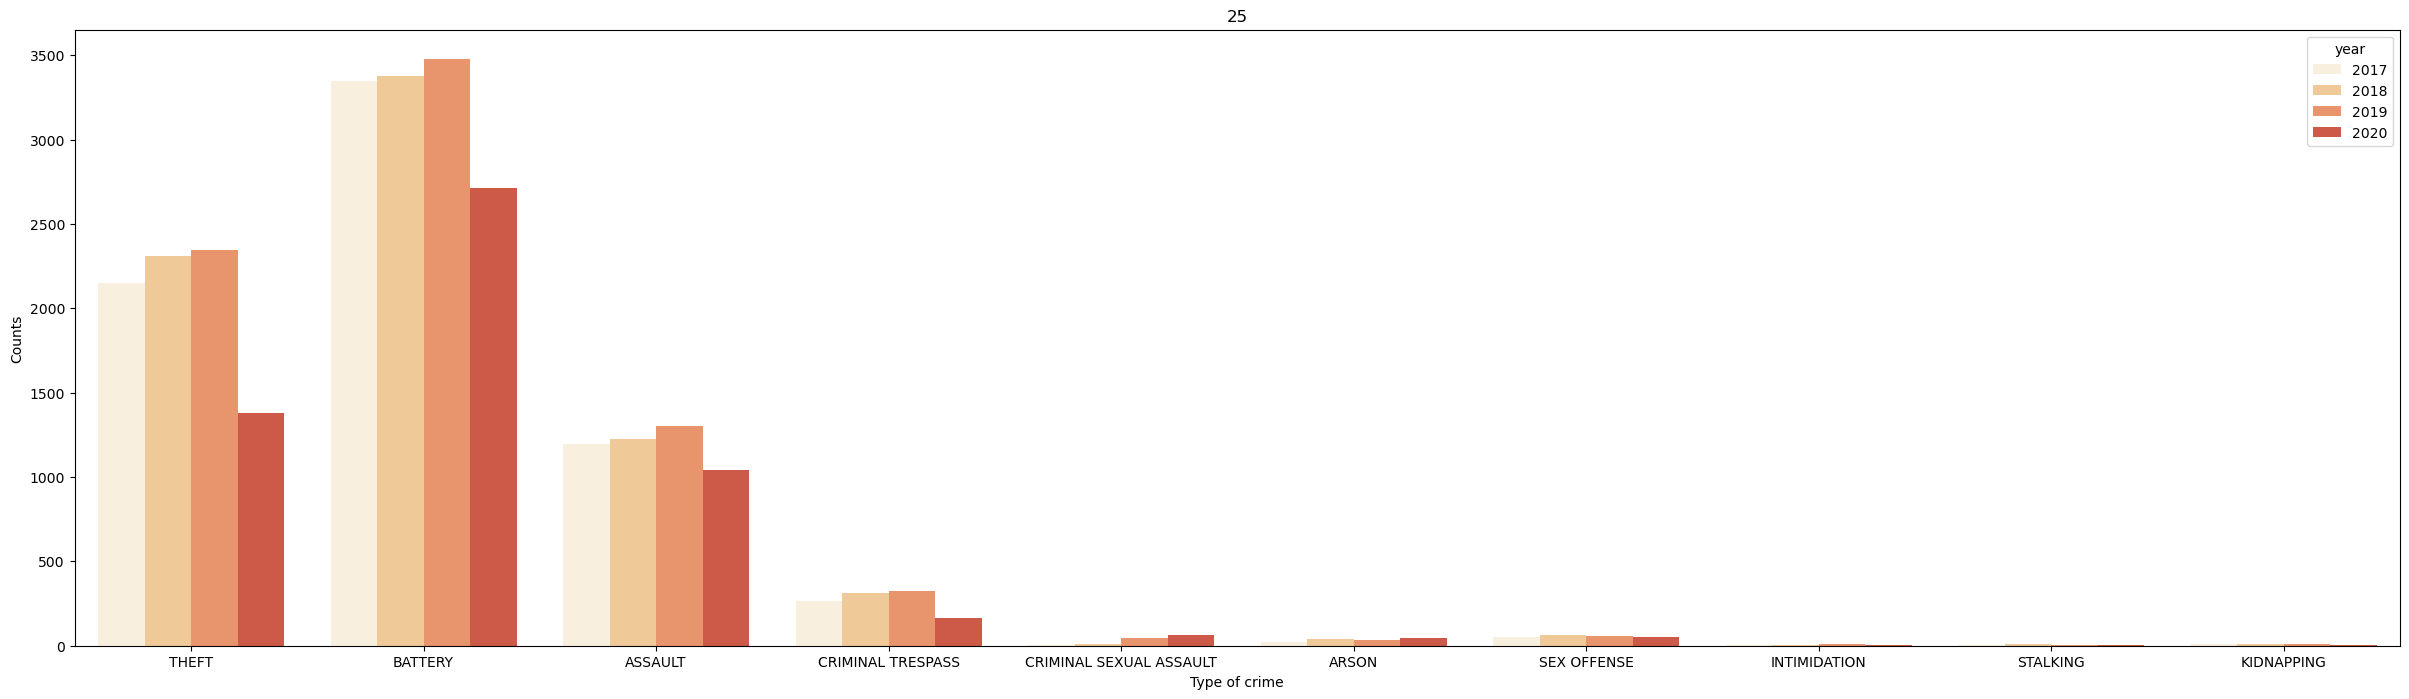

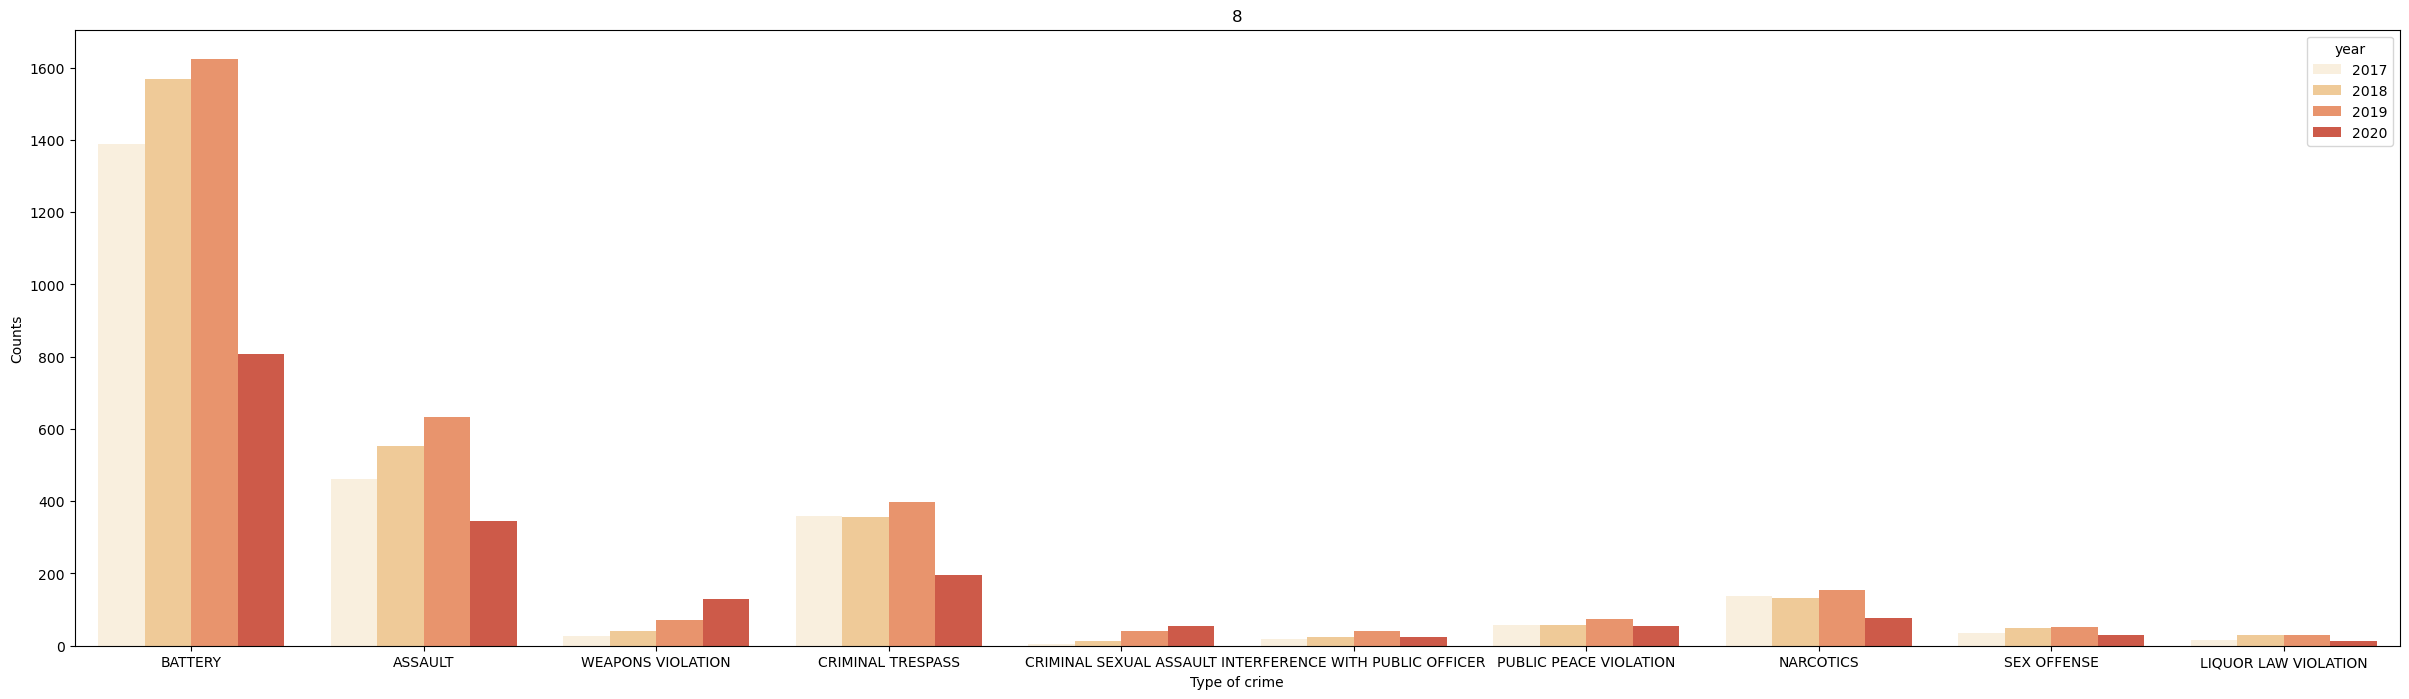

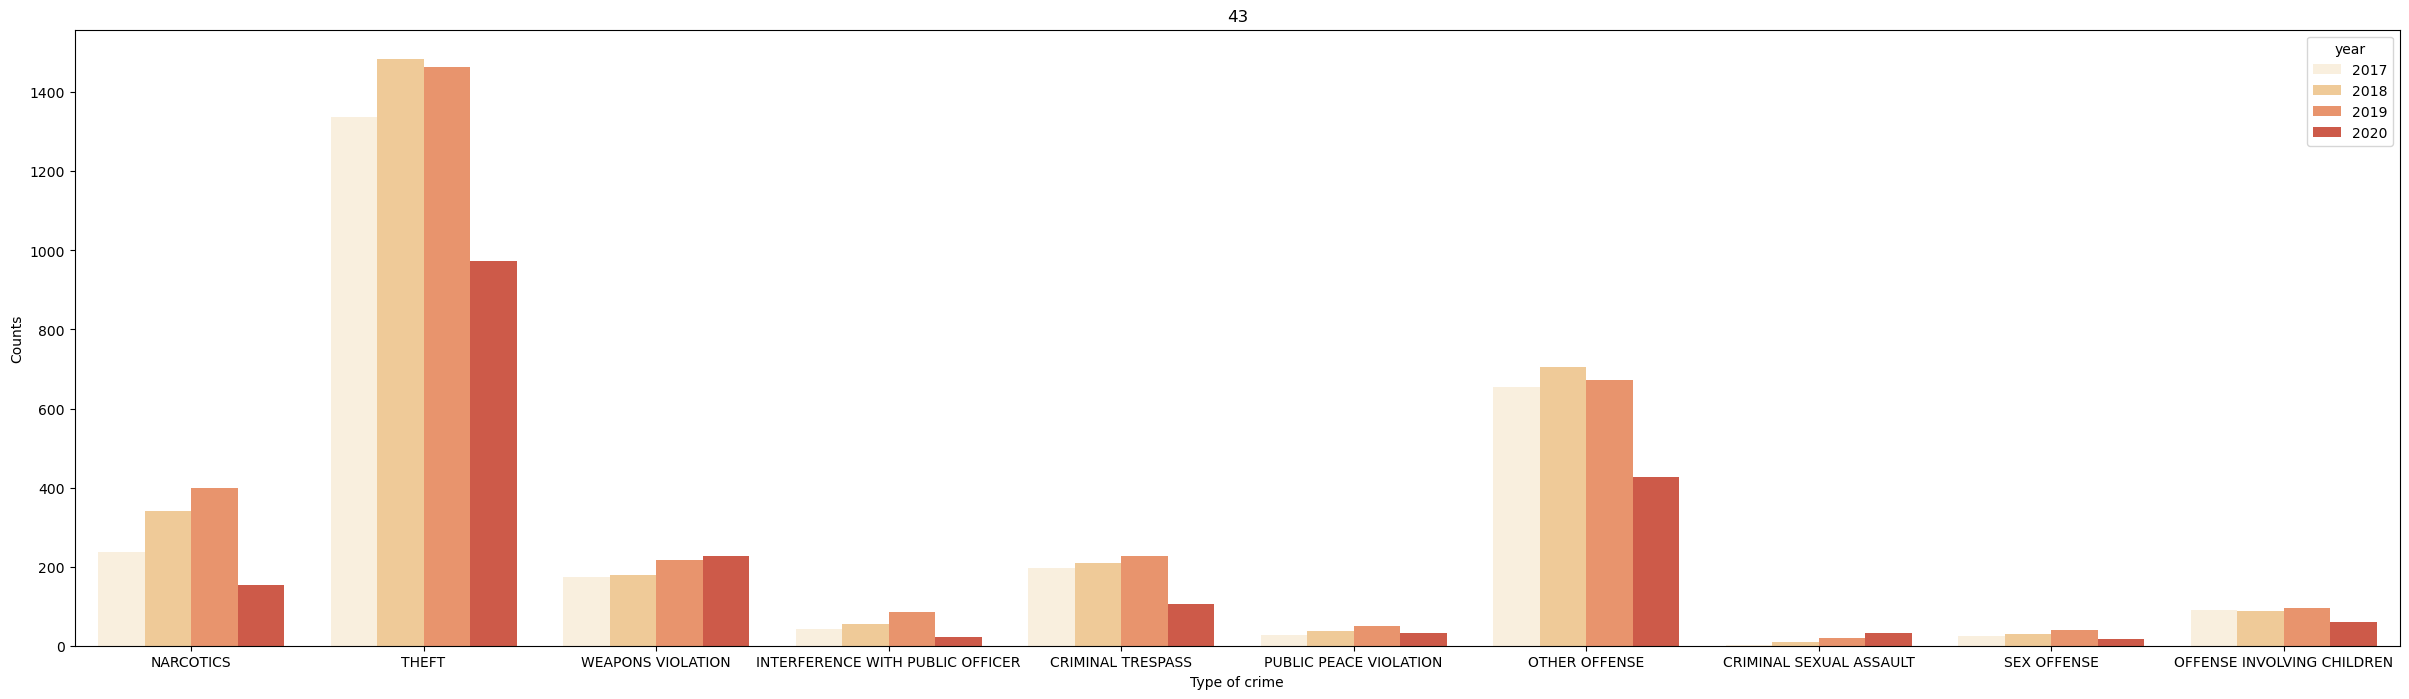

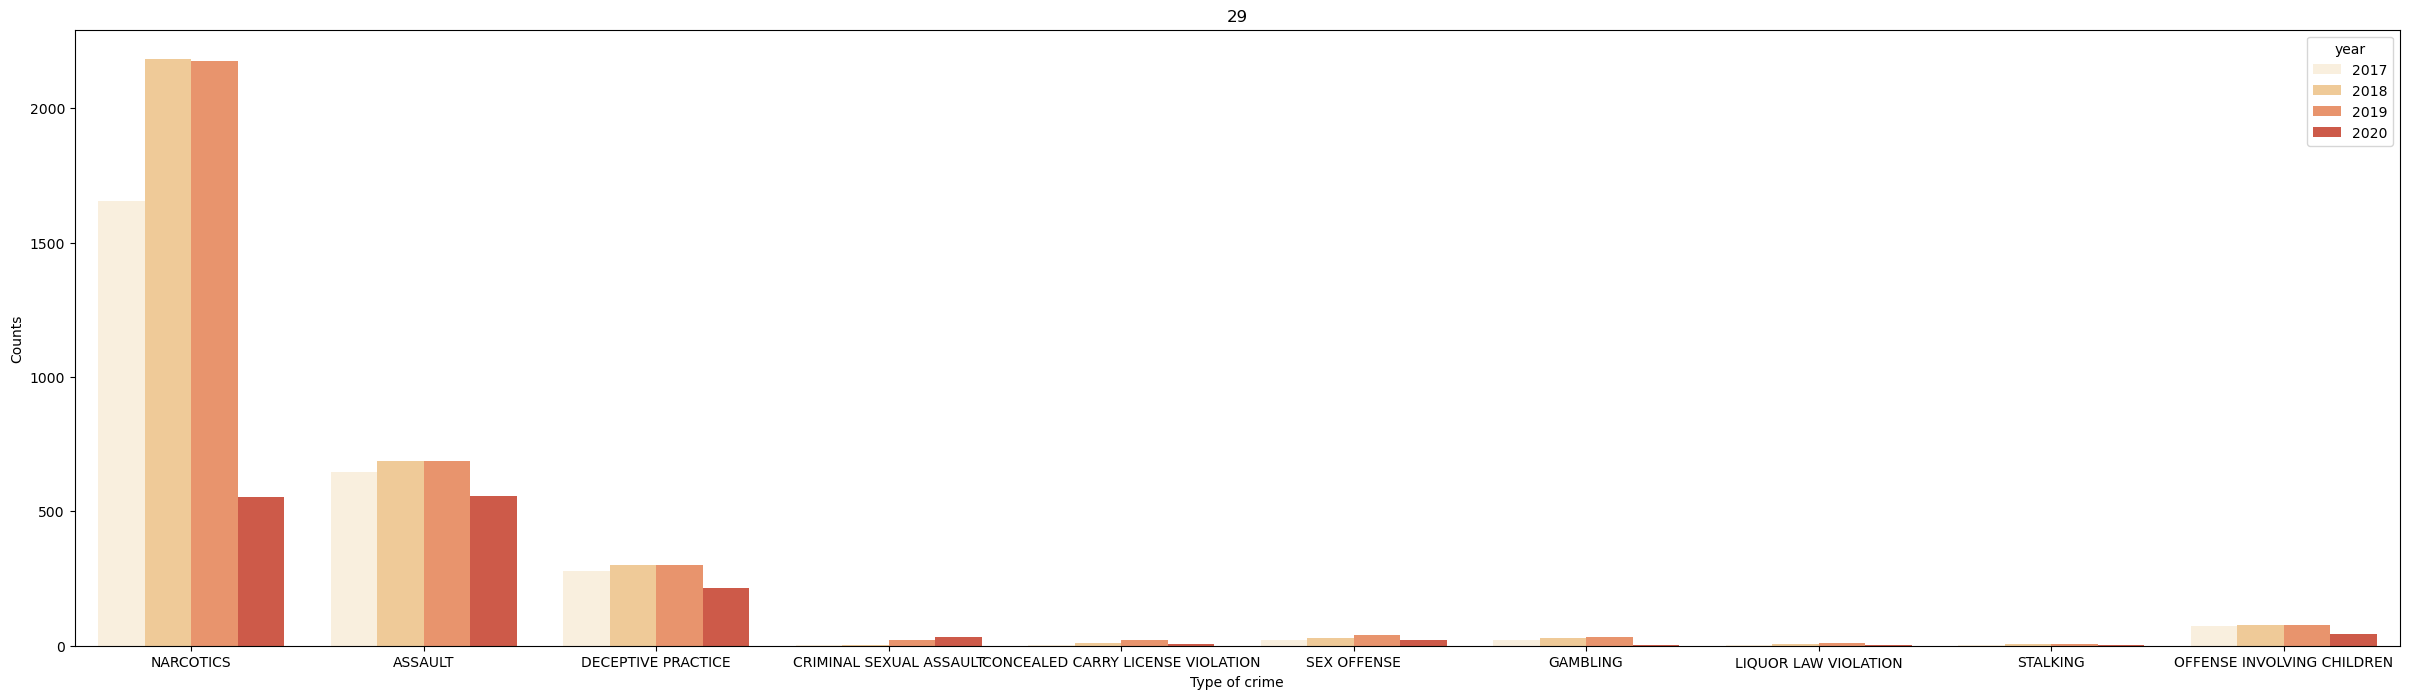

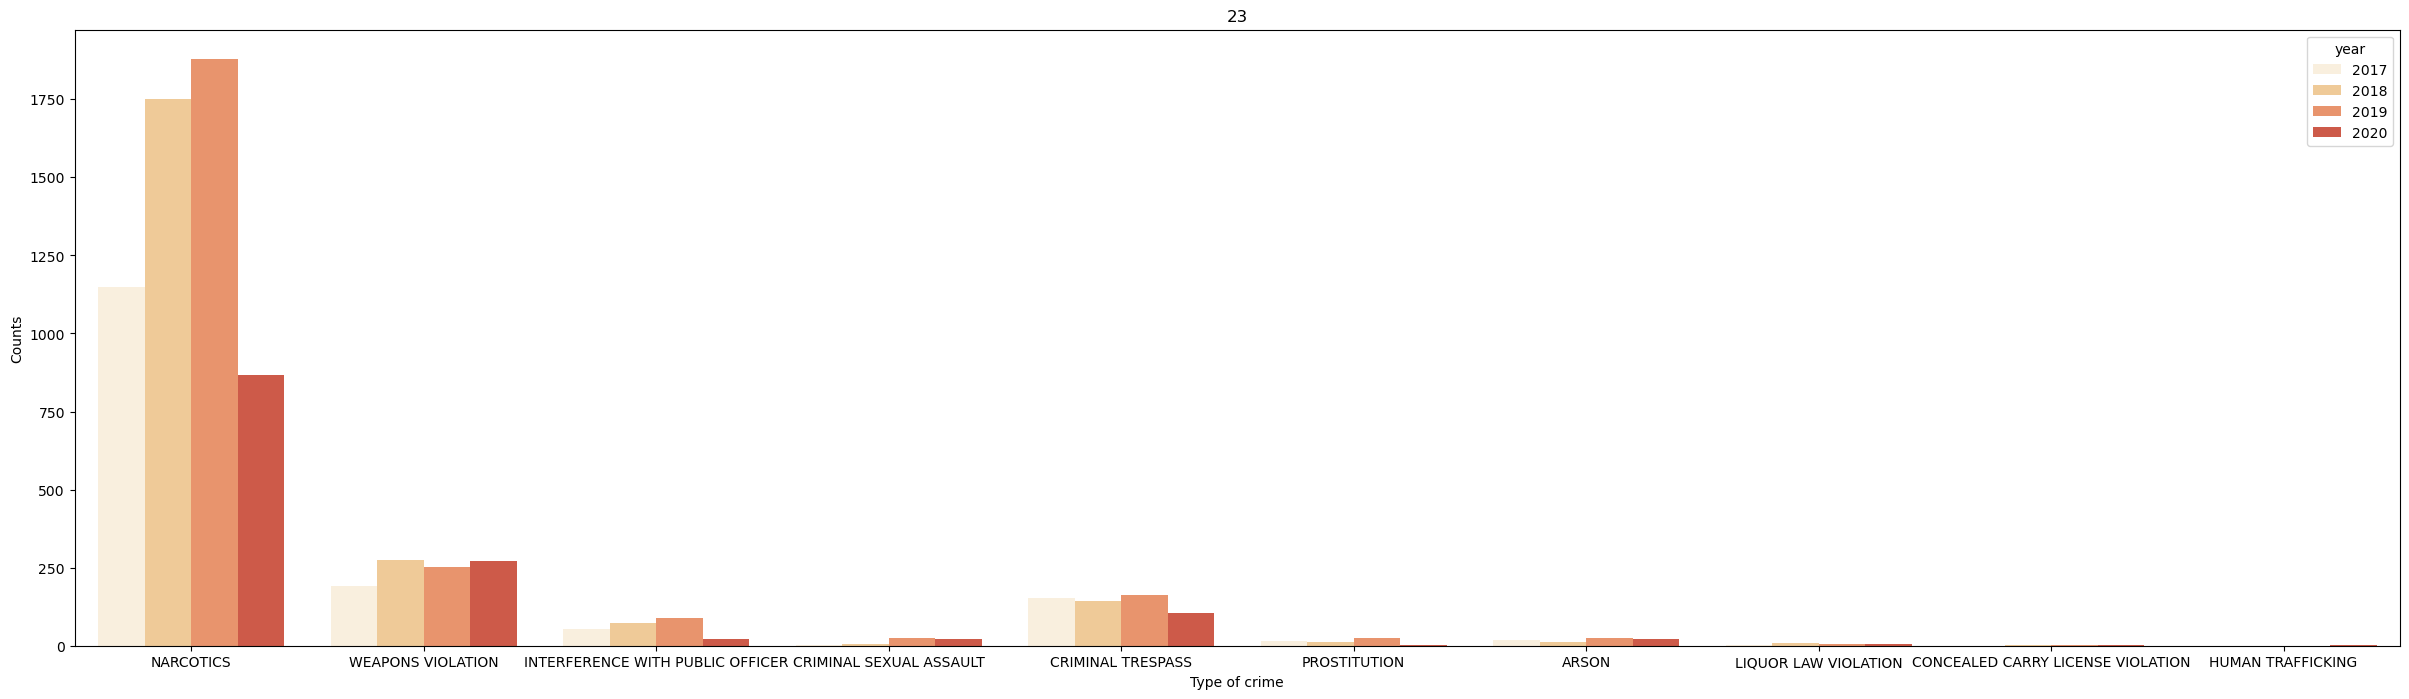

In [36]:
#Plot top 5 areas with highest crime rates
plot_change_areas([25,8,43,29,23])


In [37]:
community_crimes_lst = generate_community_crimes([25,8,43,29,23])


We observe area 23, Humboldt Park, to have the most interesting trend in crime, which is Narcotics

# Narcotics in Humboldt Park

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


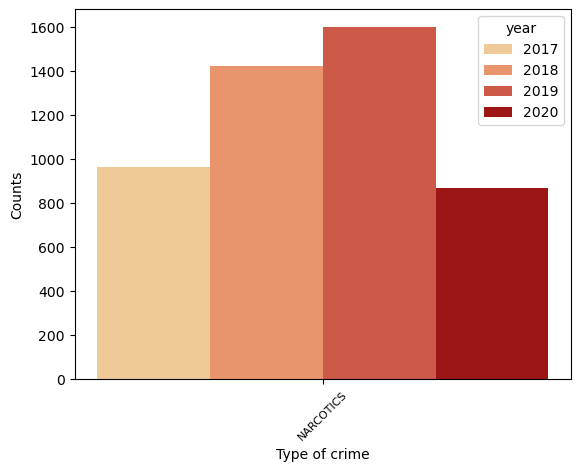

,primary_type,counts_19,counts_20,counts_18,counts_17,diff,perc_change,avg_change
1,NARCOTICS,1598,866,1423,960,-94,-0.058824,638


In [38]:
#Narcotics in Humboldt Park(area 23)
community_crimes_2019 = pd.DataFrame(crimes[(crimes["ds"] >= '2019-01-01') & (crimes["ds"] <= '2019-11-01') & (crimes["community_area"]==23)].groupby('primary_type').size().sort_values(ascending=False).rename('counts').reset_index())
community_crimes_2020 = pd.DataFrame(crimes[(crimes["ds"] >= '2020-01-01') & (crimes["ds"] <= '2020-11-01') & (crimes["community_area"]==23)].groupby('primary_type').size().sort_values(ascending=False).rename('counts_20').reset_index())
community_crimes_2018 = pd.DataFrame(crimes[(crimes["ds"] >= '2018-01-01') & (crimes["ds"] <= '2018-11-01') & (crimes["community_area"]==23)].groupby('primary_type').size().sort_values(ascending=False).rename('counts_18').reset_index())
community_crimes_2017 = pd.DataFrame(crimes[(crimes["ds"] >= '2017-01-01') & (crimes["ds"] <= '2017-11-01') & (crimes["community_area"]==23)].groupby('primary_type').size().sort_values(ascending=False).rename('counts_17').reset_index())


crimes_diff = community_crimes_2020.copy()


community_crimes_2020["diff"] = 0
community_crimes_2020["counts_19"] = 0
community_crimes_2020["counts_18"] = 0
community_crimes_2020["counts_17"] = 0



for j in community_crimes_2019.iloc:
    count_19 = j["counts"]
    community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"diff"]= community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"]]["counts_20"] - count_19
    community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"counts_19"]= count_19

for j in community_crimes_2018.iloc:
    count_18 = j["counts_18"]
    community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"diff"]= community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"]]["counts_20"] - count_18
    community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"counts_18"]= count_18
    
for j in community_crimes_2017.iloc:
    count_17 = j["counts_17"]
    community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"counts_17"]= count_17
    community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"],"diff"]= community_crimes_2020.loc[community_crimes_2020["primary_type"]==j["primary_type"]]["counts_20"] - count_17


#print(crimes_2020.head())

community_crimes_2020["perc_change"] = community_crimes_2020["diff"]/community_crimes_2020["counts_19"]
community_crimes_2020["avg_change"] = community_crimes_2020["counts_19"]-community_crimes_2020["counts_17"]

#print(crimes_diff.head())

community_crimes_2020 = community_crimes_2020[["primary_type","counts_19","counts_20","counts_18","counts_17","diff","perc_change","avg_change"]]
community_crimes_2020.sort_values("perc_change",ascending = False).head()

#community_crimes_2020.sort_values("perc_change")[["primary_type","perc_change"]].set_index("primary_type").plot.bar()




#community_crimes_2020.set_index("primary_type").sort_values("perc_change",ascending=False).head(5).counts_20.plot(kind='bar', color='red', ax=ax, width=width, position=0)
#community_crimes_2020.set_index("primary_type").sort_values("perc_change",ascending=False).head(5).counts_19.plot(kind='bar', color='blue', ax=ax, width=width, position=1)
#community_crimes_2020.set_index("primary_type").sort_values("perc_change",ascending=False).head(10).counts_18.plot(kind='bar', color='green', ax=ax, width=width, position=2)

community_crimes_2020 = community_crimes_2020.sort_values("avg_change",ascending=False).head(1)

count_2018 = community_crimes_2020[["primary_type","counts_18","avg_change"]]
count_2019 = community_crimes_2020[["primary_type","counts_19","avg_change"]]
count_2020 = community_crimes_2020[["primary_type","counts_20","avg_change"]]
count_2017 = community_crimes_2020[["primary_type","counts_17","avg_change"]]

count_2019 = count_2019.rename(columns={"counts_19":"counts_20"})
count_2018 = count_2018.rename(columns={"counts_18":"counts_20"})
count_2017 = count_2017.rename(columns={"counts_17":"counts_20"})
x = []
y= []
z =[]
k=[]
for i in range(1):
    x.append(2019)
for i in range(1):
    y.append(2020)
for i in range(1):
    z.append(2018)
for i in range(1):
    k.append(2017)
       
count_2019["year"] = x
count_2020["year"] = y
count_2018["year"] = z
count_2017["year"] = k

count_all = pd.concat([count_2018,count_2017,count_2019,count_2020],ignore_index=True) 

fig = plt.figure()# Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
width = 0.4

sns.barplot(x=count_all.primary_type,y=count_all.counts_20,hue=count_all.year,palette = ['#fdcc8a','#fc8d59','#e34a33','#b30000']) ##fef0d9',

count_all 
plt.xlabel("Type of crime")
plt.ylabel("Counts")
plt.xticks(rotation=45,size=8)
plt.show()
community_crimes_2020





In [42]:

trending_crimes = []

for i in community_crimes_lst:
    for j in i[1].iloc():
        if  j["primary_type"] == "NARCOTICS" :#j["perc_change"]> 0.1 and j["counts_20"]>300 and
            trending_crimes.append([i[0],j["primary_type"],j["perc_change"],j["counts_20"],j["primary_type"],j["counts_17"],j["17_diff"]])

trending_crimes
trending_crimes_df = pd.DataFrame(trending_crimes)
trending_crimes_df


df1 = trending_crimes_df.head()


df1 = df1.drop(columns=[1])
df1 = df1.set_index(0)

df1.columns.name = df1.index.name
df1.index.name = None
df1 = df1.rename(columns={2:"Percentage",4:"Primary_type",5:"Counts_17",6:"a17_diff"})
df1["Percentage"] = df1["Percentage"]*100

area_lst = ['Austin','Near North Side','North Lawndale','Auburn Gresham','Humboldt Park',]#West Englewood','Greater Grand Crossing','Englewood','Lincoln Square']
area_lst = area_lst[:7]
#area_lst = pd.DataFrame(area_lst,columns=['areas'])

df1["area_lst"] = area_lst
df1 = df1.set_index("area_lst")
fig = plt.figure()
ax = sns.barplot(x=df1.index, y=df1.a17_diff,data=df1,palette=['#274950','#2D9991','#E7AB7A','#F1906C','#E36656'])
ax.set_xlabel("Community area")
plt.xticks(size=8)
ax.set_ylabel("Increase in incidetns from 2017")
#for i in range(9):
 #   plt.text(x=i-1+0.5,y=df1["Percentage"].iloc()[i],s=df1["Primary_type"][i],size=8,rotation=0)
counter = 0
"""for p in ax.patches:
    
    percentage = df1["Primary_type"].iloc()[counter]
    x = p.get_x() + p.get_width() -0.8
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y),rotation=0,size=8)
    counter += 1
  """  
df1

,Percentage,3,Primary_type,Counts_17,a17_diff
area_lst,,,,,
Austin,-74.940523,516,NARCOTICS,1461,-200
Near North Side,-40.000000,76,NARCOTICS,138,17
North Lawndale,-20.351759,156,NARCOTICS,237,161
Auburn Gresham,-50.114943,563,NARCOTICS,1653,522
Humboldt Park,-13.038850,903,NARCOTICS,1148,731


In [45]:
import pandas as pd
#Tar inn en liste av primary_types, og område, og returnerer en liste klar for prophet.
def prophet_data_area(primary_type_lst,area):
    prophet_m_lst = []
    prophet_forecast_lst = []
    for primary_type in primary_type_lst:
        crime = crimes[(crimes["primary_type"] == primary_type) & (crimes["community_area"]==area)]
        crime_days = crime.groupby(pd.Grouper(key="ds", freq="1D")).count()
        df = pd.DataFrame()
        df["ds"] = crime_days.index
        try:
            df[["y","y1","y2"]] = crime_days.values
        except: 
            df[["y","y1","y2","y3"]] = crime_days.values
        m = Prophet(seasonality_mode = 'multiplicative')
        m.fit(df)
        future = m.make_future_dataframe(periods=365, freq='d')
        forecast = m.predict(future)
        prophet_m_lst.append(m)
        prophet_forecast_lst.append(forecast)
    return prophet_m_lst, prophet_forecast_lst
    

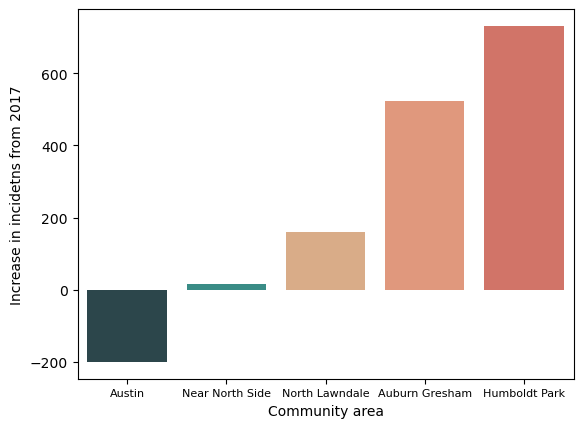

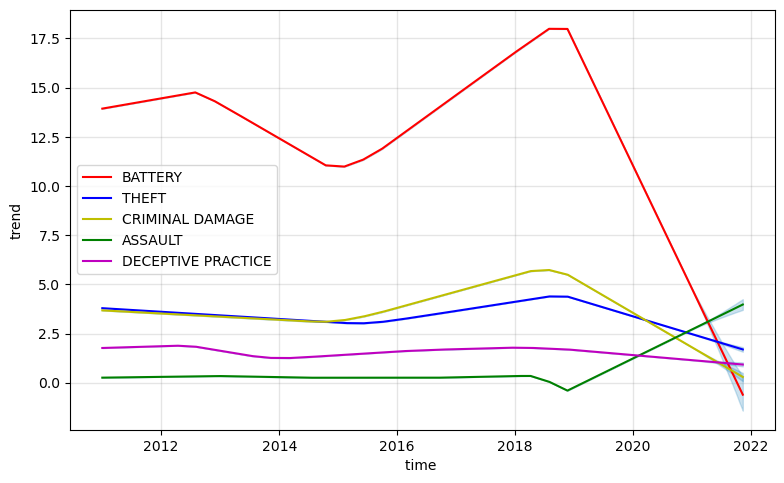

In [46]:
top_trending_crimes_community = community_crimes_lst[1][1].head(5)["primary_type"]

prophet_m_lst,prophet_forecast_lst = prophet_data_area(top_trending_crimes_community,community_crimes_lst[1][0])

#Plot alle crimes i samme figur
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(2, 2, 1)
col_lst =['r','b','y','g','m']
for i in range(len(prophet_m_lst)):
    fig = plot_new_forecast_component(m=prophet_m_lst[i], fcst=prophet_forecast_lst[i], name='trend',col=col_lst[i],ax=ax1)
    plt.legend(crime_count.head()["primary_type"])
plt.show()